# IMPORTS

In [ ]:
from matplotlib import pyplot as plt
import random
import itertools
from keras.datasets import mnist
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# SASVI

In [2]:
def get_a(lambda1, θ1star):
    return(-θ1star+y/lambda1)

def get_b(lambda2, θ1star):
    return(-θ1star+y/lambda2)

def x_ort(x,a,b):
    return(x-np.outer(a,np.dot(x.T,a))/(np.linalg.norm(a)**2))

def y_ort(y,a,b):
    return(y-a*np.dot(y,a)/(np.linalg.norm(a)**2))

In [3]:
def sasvi(X,a,b,λ1,λ2, θ1star, Xort, yort, p):

    if(np.all(a)!=0):

        bool_vec=(np.any(a)!=0 and np.dot(b,a)/(np.linalg.norm(b)*np.linalg.norm(a))>np.abs(np.dot(X.T,a))/np.linalg.norm(X,axis=0)*np.linalg.norm(a))
        uplus=bool_vec*np.dot(X.T,θ1star)+(1/λ2-1/λ1)/2*(np.linalg.norm(Xort,axis=0)*np.linalg.norm(yort)+np.dot(Xort.T,yort))
        uminus=bool_vec*(-np.dot(X.T,θ1star))+(1/λ2-1/λ1)/2*(np.linalg.norm(Xort,axis=0)*np.linalg.norm(yort)-np.dot(Xort.T,yort))

        bool_vec=(((np.dot(X.T,a)>0) & (np.dot(b,a)/(np.linalg.norm(b)*np.linalg.norm(a))<=np.dot(X.T,a)/np.linalg.norm(X,axis=0)*np.linalg.norm(a))))
        uminus+=bool_vec*(-np.dot(X.T,θ1star)+1/2*(np.linalg.norm(X,axis=0)*np.linalg.norm(b)-np.dot(X.T,b)))

        bool_vec=(((np.dot(X.T,a)<0) & (np.dot(b,a)/(np.linalg.norm(b)*np.linalg.norm(a))<=-np.dot(X.T,a)/np.linalg.norm(X,axis=0)*np.linalg.norm(a))))
        uplus+=bool_vec*(np.dot(X.T,θ1star)+1/2*(np.linalg.norm(X,axis=0)*np.linalg.norm(b)+np.dot(X.T,b)))

    else:
        uminus=(-np.dot(X.T,θ1star)+1/2*(np.linalg.norm(X,axis=0)*np.linalg.norm(b)-np.dot(X.T,b)))
        uplus=(np.dot(X.T,θ1star)+1/2*(np.linalg.norm(X,axis=0)*np.linalg.norm(b)+np.dot(X.T,b)))
        
    
    return(np.where((uplus<1) & (uminus<1)))





# Other screening rules

In [4]:
def strong_rule(X,y,theta_before, lamb, lamb_before):
    """
    Strong rule algorithm.

    An heuristic rule which try to eliminate features that are guaranteed to have
    zero coefficients in Lasso problem. It might mistakenly discard active features.

    Parameters
    ----------
    X : np.ndarray of shape (n,p)
        Input design matrix. n is the number of elements 
        and p the number of features
    y : np.ndarray of shape (n,1)
        The response vector
    theta_before : np.ndarray of shape (p,1)
        The vector containing the model coefficients of the LASSO model 
        defined on X for the design matrix and lamb_before for the regularization 
        parameter
    lamb : float
        The regularization parameter for the new model
    lamb_before : float
        The regularization parameter of the precedent model

    Return
    ------
    An upper bound of |<x_j, theta_before>| for all the features j in [1,...,j]

    """

    return np.where(((lamb_before/lamb)*np.abs(np.dot(X.T,theta_before)) + ((lamb_before/lamb) -1))<1)

def safe_screening(X,y,theta_before, lamb, lamb_before):
    s_star = np.max([np.min([np.dot(theta_before.T,y)/(lamb*np.linalg.norm(theta_before)),1]),-1])
    return np.where((np.abs(np.dot(X.T,y))/lamb + np.linalg.norm(X,axis=0)*np.linalg.norm(s_star*theta_before-y/lamb))<1)

# Functions to compare methods and plot the comparison

In [5]:
def test_method(X,y,λ,λ_max, verbose=False):
    p=len(X[1,:])
    β=np.zeros(50000)


    Tsasvi=[]
    Tnormal=[]
    Tstrong=[]
    Tsafe=[]


    nb_removed_sasvi=[]
    nb_removed_strong=[]
    nb_removed_safe=[]



    for i in range(len(λ)-1):
        if(verbose):
            print("#### Step n°{}/{} ####".format(i+1,len(λ)-1))

        θ1star=(y-np.dot(X,β))/λ[i]
        a=get_a(λ[i], θ1star)
        b=get_b(λ[i+1], θ1star)
        yort=y_ort(y,a,b)
        Xort=x_ort(X,a,b)
        
        #SASVI SCREENING AND FITTING
        start=time.time()
        to_drop_sasvi=sasvi(X,a,b,λ[i],λ[i+1], θ1star, Xort,yort, p)
        tmp_time=(time.time()-start)

        X_sasvi = np.delete(X, to_drop_sasvi, 1)
        nb_removed_sasvi.append(np.shape(to_drop_sasvi)[1])
        if(verbose):
            print("Number of variables removed with sasvi :",np.shape(to_drop_sasvi)[1])

        start=time.time()
        clf = linear_model.Lasso(alpha=λ[i+1])
        clf.fit(X_sasvi,y)
        Tsasvi.append(tmp_time+time.time()-start)

        #STRONG RULE SCREENING AND FITTING
        to_drop_strong=strong_rule(X,y,θ1star, λ[i+1], λ[i])
        X_strong = np.delete(X, to_drop_strong, 1)
        nb_removed_strong.append(np.shape(to_drop_strong)[1])
        if(verbose):
            print("Number of variables removed with strong rule :",np.shape(to_drop_strong)[1])

        start=time.time()
        clf = linear_model.Lasso(alpha=λ[i+1])
        clf.fit(X_strong,y)
        Tstrong.append(time.time()-start)

        #SAFE RULE SCREENING AND FITTING
        to_drop_safe=safe_screening(X,y,θ1star, λ[i+1], λ[i])
        X_safe = np.delete(X, to_drop_safe, 1)
        nb_removed_safe.append(np.shape(to_drop_safe)[1])
        if(verbose):
            print("Number of variables removed with safe rule :",np.shape(to_drop_safe)[1])

        start=time.time()
        clf = linear_model.Lasso(alpha=λ[i+1])
        clf.fit(X_safe,y)
        Tsafe.append(time.time()-start)


        #NO SCREENING FITTING  
        start=time.time()
        clf = linear_model.Lasso(alpha=λ[i+1])
        clf.fit(X,y)
        Tnormal.append(time.time()-start)
        β=clf.coef_
        
    return(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe)

In [6]:
def plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe, λ, λ_max):

    plt.figure(figsize=(12,8))
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tnormal,label='Normal')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tsasvi,label='Sasvi')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tstrong,label='Strong')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tsafe,label='Safe')
    plt.legend()
    plt.xlabel("λ/λ_max")
    plt.ylabel("Time")
    plt.title("Time to compute as a function of λ/λ_max")

    plt.figure(figsize=(12,8))
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_sasvi)/50000,label='Sasvi')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_strong)/50000,label='Strong')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_safe)/50000,label='Safe')
    plt.legend()
    plt.xlabel("λ/λ_max")
    plt.ylabel("Nb removed/Total nb of variables")
    plt.title("Proportion of removed variables as a function of λ/λ_max")

# MNIST example

In [7]:
def gen_data_MNIST():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    ind=[[]]*10
    for i in range(10):
        ind[i]=random.sample([j for j in range(np.shape(train_X)[0]) if train_y[j]==i],5000)
    ind=list(itertools.chain.from_iterable(ind))
    X=np.zeros([784,50000])
    for i in range(50000):
        X[:,i]=train_X[ind[i]].flatten()
    y=test_X[random.sample(range(np.shape(test_y)[0]),1)[0]].flatten()
    return(X,y)

In [8]:
[X,y]=gen_data_MNIST()
p=len(X[1,:])
λ_max=np.max(np.abs(np.dot(y,X)))
λ=np.linspace(1,0.05,20)*λ_max

#### Step n°1/19 ####
Number of variables removed with sasvi : 49992
Number of variables removed with strong rule : 49970
Number of variables removed with safe rule : 6573
#### Step n°2/19 ####
Number of variables removed with sasvi : 49964
Number of variables removed with strong rule : 49925
Number of variables removed with safe rule : 4694
#### Step n°3/19 ####
Number of variables removed with sasvi : 49910
Number of variables removed with strong rule : 49795
Number of variables removed with safe rule : 3183
#### Step n°4/19 ####
Number of variables removed with sasvi : 49723
Number of variables removed with strong rule : 49466
Number of variables removed with safe rule : 2001
#### Step n°5/19 ####
Number of variables removed with sasvi : 49331
Number of variables removed with strong rule : 48918
Number of variables removed with safe rule : 1164
#### Step n°6/19 ####
Number of variables removed with sasvi : 48667
Number of variables removed with strong rule : 48003
Number of variable

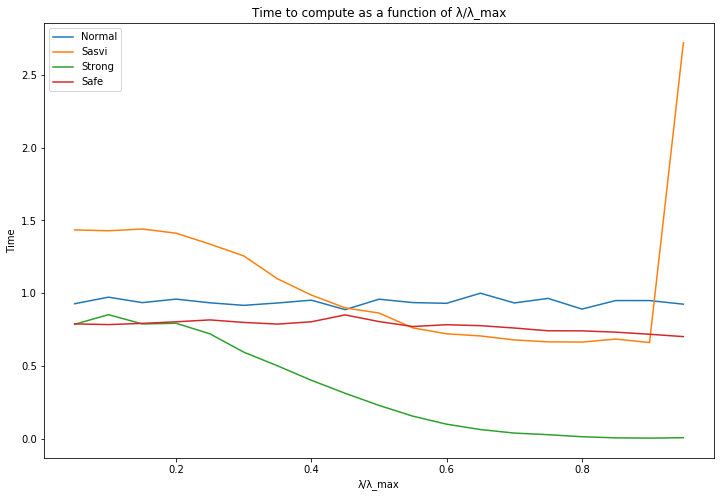

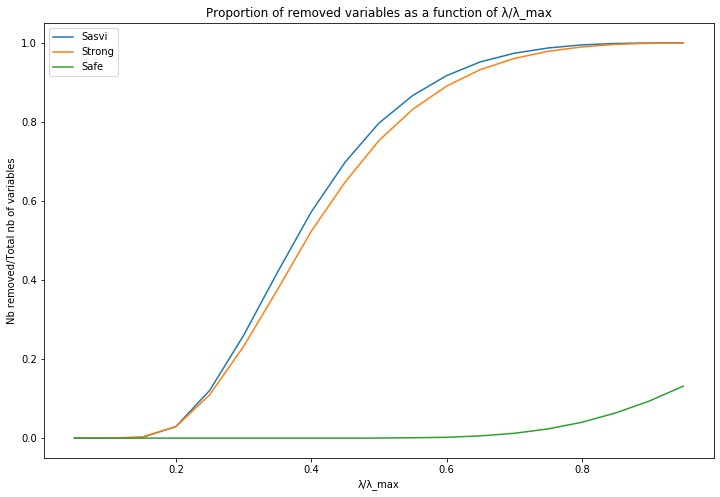

In [9]:
Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe=test_method(X,y, λ, λ_max,True)
plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe,λ, λ_max)